In [1]:
from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
from env.cartpole_obs import CartPoleObs
from env.cartpole import CartPole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd

import pickle
obs_list = []
width = 4.
near = width * 1.2
H = 0.5
L = 2.5

# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
for i in range(2):
    file = open('data/cartpole_obs/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('data/cartpole_obs/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))


obs_idx = 0
p_idx = 0
# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

generated.
(6, 2)


In [2]:
# load path
path = open('data/cartpole_obs/%d/path_%d.pkl' % (obs_idx, p_idx), 'rb')
path = pickle.load(path)
controls = open('data/cartpole_obs/%d/control_%d.pkl' % (obs_idx, p_idx), 'rb')
controls = pickle.load(controls)

In [3]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer



class CartPoleVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CartPoleVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-20, 20)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,params['cart_h']))
        # print location of cart
        return self.recs


 
    def animate(self, states, actions, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            s = states[i]
            action = actions[i]
            sT = states[i+1]
            # propogate until reaching next state
            while True:
                traj.append(np.array(s))
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                if np.linalg.norm(s-sT) == 0.:
                    break
        traj = np.array(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(0, len(self.states)),
                                      interval=self.dt*10, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


state: 0, remaining: 20
state: 1, remaining: 19
state: 2, remaining: 18
state: 3, remaining: 17
state: 4, remaining: 16
state: 5, remaining: 15
state: 6, remaining: 14
state: 7, remaining: 13
state: 8, remaining: 12
state: 9, remaining: 11
state: 10, remaining: 10
state: 11, remaining: 9
state: 12, remaining: 8
state: 13, remaining: 7
state: 14, remaining: 6
state: 15, remaining: 5
state: 16, remaining: 4
state: 17, remaining: 3
state: 18, remaining: 2
animating...
2121


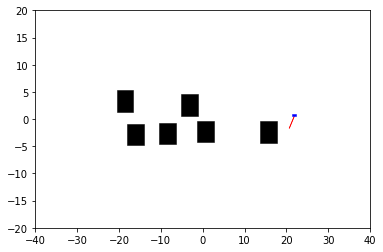

In [4]:
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.1
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002
system = CartPole(obs_list)
vis = CartPoleVisualizer(system, params)
states = path
actions = controls
anim = vis.animate(np.array(states), np.array(actions), obs_list)
HTML(anim.to_html5_video())
#anim.save('cartpole_env%d_path%d.mp4' % (obs_idx, p_idx))

(6, 1400, 2)
(8400, 2)


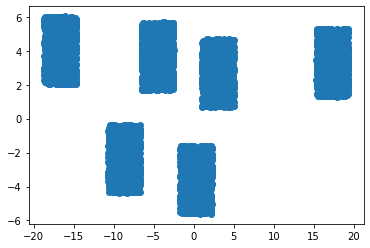

In [5]:
# visualize point cloud
import matplotlib.pyplot as plt
print(obc_list.shape)
obc_all = np.concatenate(obc_list_total[1], axis=0)
print(obc_all.shape)
plt.scatter(obc_all[:,0], obc_all[:,1])
plt.show()

(8400, 2)


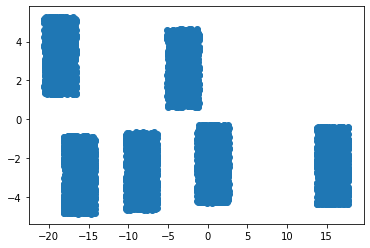

(8400, 2)


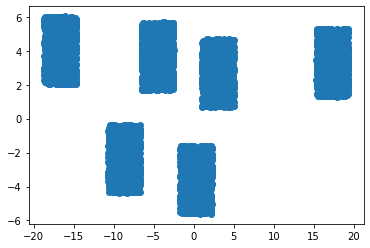

In [6]:
for i in range(2):
    obc_all = np.concatenate(obc_list_total[i], axis=0)
    print(obc_all.shape)
    plt.scatter(obc_all[:,0], obc_all[:,1])
    plt.show()